In [1]:
import os 
import sys
sys.path.append('/home/lytq/SEDR/DeepST-main/deepst')
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

data_path = "/home/lytq/SEDR/data" 
data_name = "Stero-seq"
save_path = "/home/lytq/SEDR/results/DeepST/Stereo-seq" 
os.makedirs(save_path, exist_ok=True)
n_domains = 10 

deepen = run(save_path = save_path,
	task = "Identify_Domain", 
	pre_epochs = 800, 
	epochs = 1000, 
	use_gpu = True)

###### Read in other spatial data, or user can read in themselves. Including original expression
###### information and spatial location information, where the location information is saved in .obsm["spatial"]
# adata = deepen._get_adata(platform="stereoSeq", data_path=data_path, data_name=data_name)
data_root = Path('./data/Stero-seq')
if not os.path.exists(data_root / 'raw.h5ad'):
    counts = pd.read_csv(data_root / 'RNA_counts.tsv.gz', sep='\t', index_col=0).T
    counts.index = [f'Spot_{i}' for i in counts.index]
    adata = sc.AnnData(counts)
    adata.X = csr_matrix(adata.X, dtype=np.float32)

    df_pos = pd.read_csv(data_root / 'position.tsv', sep='\t')
    adata.obsm['spatial'] = df_pos[['y','x']].values

    used_barcode = pd.read_csv(os.path.join(data_root / 'used_barcodes.txt'), sep='\t', header=None)
    used_barcode = used_barcode[0]
    adata = adata[used_barcode,]

    adata.write( data_root / 'raw.h5ad')
else:
    adata = sc.read_h5ad( data_root / 'raw.h5ad')

###### Data augmentation. spatial_type includes three kinds of "KDTree", "BallTree" and "LinearRegress", among which "LinearRegress"
###### is only applicable to 10x visium and the remaining omics selects the other two.
###### "use_morphological" defines whether to use morphological images.
adata = deepen._get_augment(adata, spatial_type="BallTree", use_morphological=False)

###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")

###### Enhanced data preprocessing
data = deepen._data_process(adata, pca_n_comps = 200)

###### Training models
deepst_embed = deepen._fit(
		data = data,
		graph_dict = graph_dict,)
###### DeepST outputs
adata.obsm["DeepST_embed"] = deepst_embed

###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)

Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!
12.0000 neighbors per cell on average.
Step 2: Graph computing is Done!
Your task is in full swing, please wait


DeepST trains an initial model: 100%|██████████ [ time left: 00:00 ]
DeepST trains a final model: |           [ time left: 00:00 ]    


Step 3: DeepST training has been Done!
Current memory usage：17.3600 GB
Total time: 7.19 minutes
Your task has been completed, thank you
Of course, you can also perform downstream analysis on the processed data
Best resolution:  0.6899999999999997


In [33]:
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)

Best resolution:  0.6899999999999997


In [34]:
print(adata)
print(adata.obs['DeepST_refine_domain'])
print(adata.obs['DeepST_refine_domain'].value_counts())
print(adata.obs['DeepST_domain'])
print(adata.obs['leiden'])
print(adata.obs['leiden'].value_counts())

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'leiden', 'DeepST_domain', 'DeepST_refine_domain'
    uns: 'neighbors', 'leiden', 'DeepST_refine_domain_colors'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'
Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     1
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_refine_domain, Length: 19109, dtype: object
0    4948
1    4258
2    2814
4    2013
3    1984
5    1900
6    1094
7      75
8      15
9       8
Name: DeepST_refine_domain, dtype: int64
Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     1
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_domain, Length: 19109, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
Spot_1        2
Spo

In [7]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain
Spot_1,2,2,2
Spot_10,2,2,2
Spot_100,2,2,2
Spot_1000,1,1,1
Spot_10000,2,2,2
...,...,...,...
Spot_9994,2,2,2
Spot_9995,2,2,2
Spot_9996,2,2,2
Spot_9998,2,2,2


In [37]:
adata.obs['DeepST_domain'].value_counts

<bound method IndexOpsMixin.value_counts of Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     1
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_domain, Length: 19109, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']>

In [38]:
adata.obs['DeepST'] = adata.obs['DeepST_refine_domain'].astype('int64')

In [23]:
adata.obs['DeepST_refine_domain'].value_counts

<bound method IndexOpsMixin.value_counts of Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     1
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_refine_domain, Length: 19109, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']>

In [28]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain
Spot_1,2,2,2
Spot_10,2,2,2
Spot_100,2,2,2
Spot_1000,1,1,1
Spot_10000,2,2,2
...,...,...,...
Spot_9994,2,2,2
Spot_9995,2,2,2
Spot_9996,2,2,2
Spot_9998,2,2,2


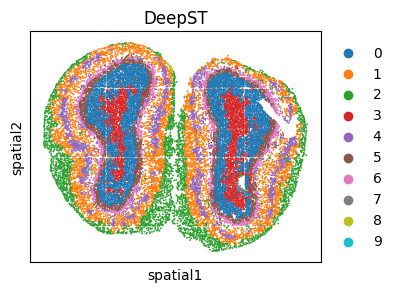

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sc.pl.spatial(adata, color='DeepST_refine_domain', title='DeepST', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()
plt.savefig(os.path.join(save_path, f'spatial_clusters.png'), bbox_inches='tight', dpi=300)

In [41]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain,DeepST
Spot_1,2,2,2,2
Spot_10,2,2,2,2
Spot_100,2,2,2,2
Spot_1000,1,1,1,1
Spot_10000,2,2,2,2
...,...,...,...,...
Spot_9994,2,2,2,2
Spot_9995,2,2,2,2
Spot_9996,2,2,2,2
Spot_9998,2,2,2,2


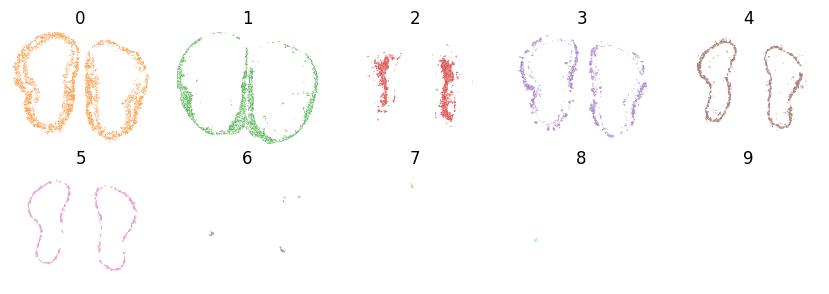

In [45]:
fig, axes = plt.subplots(2,5,figsize=(1.7*5, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_domains):
    sub = adata[adata.obs['DeepST'] == i+1]
    sc.pl.spatial(sub, spot_size=30, color='DeepST_refine_domain', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i)
    
xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'{data_name}_each_cluster.png'), bbox_inches='tight', dpi=300)